# Avaliando algoritmos para o caminho mais curto em grafos urbanos

Este trabalho tem como objetivo avaliar o comportamento de três algoritmos de menor caminho, aplicados ao cenário de roteamento para serviços de emergência, partindo do Hospital Walfredo Gurgel em direção a diferentes bairros de Natal/RN. Em casos de urgência, o tempo de resposta pode ser decisivo para salvar vidas. Por isso, é fundamental que a rota traçada até o destino percorra a menor distância possível no menor tempo.

Neste contexto, serão comparados, para os três algoritmos, os seguintes aspectos: a distância da rota traçada, o desempenho computacional (tempo de execução) e o impacto ambiental (pegada de carbono).

O trabalho pode ser dividido nas seguintes etapas: coleta de dados e definição de pontos de interesse, implementação dos algoritmos e visualização dos resultados.


In [ ]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 2.2 MB/s eta 0:00:00


In [ ]:
!pip install codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 576.4/576.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: termcolor
    Found existing installation: termcolor 3.1.0
    Uninstalling termcolor-3.1.0:
      Successfully uninstalled termcolor-3.1.0
  Attempting uninstall: psutil
    Found existing installation: psutil 5.9.5
    Uninstalling psutil-5.9.5:
      Successfully uninstalled psutil-5.9.5
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take int

In [ ]:
#importe das bibliotecas necessárias
import networkx as nx
import osmnx as ox
from networkx import path_weight
import time
from codecarbon import EmissionsTracker


#Dados e pontos de Interesse

As análises foram realizadas utilizando o mapa da cidade de Natal, obtido por meio da biblioteca OSMNx, além da seleção dos 10 bairros mais populosos da cidade, com base no [Censo de 2022](https://g1.globo.com/rn/rio-grande-do-norte/noticia/2024/11/14/censo-2022-se-fosse-uma-cidade-maior-bairro-de-natal-seria-o-7o-municipio-mais-populoso-do-rn-veja-lista.ghtml). Os bairros selecionados foram: Nossa Senhora da Apresentação, Pajuçara, Potengi, Felipe Camarão, Planalto, Lagoa Nova, Ponta Negra, Alecrim, Lagoa Azul e Candelária.

Algumas etapas de processamento são comuns aos três algoritmos e, por isso, foram implementadas no início do notebook. Entre essas etapas, estão: a construção do grafo da cidade, a criação da lista com os bairros, a obtenção das coordenadas e a identificação dos nós vizinhos mais próximos da origem e do destino.

A origem de todas as rotas é fixa — o Hospital Walfredo Gurgel —, variando apenas o destino, que corresponde aos diferentes bairros selecionados.



In [ ]:
# Baixar o grafo da cidade (modo 'drive' é ideal para carros)
G = ox.graph_from_place("Natal, Rio Grande do Norte, Brazil", network_type='drive')

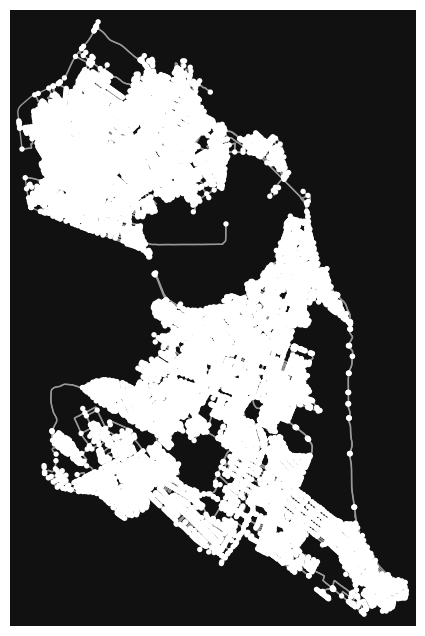

In [ ]:
#visualização do mapa de  Natal
fig, ax = ox.plot.plot_graph(G)

In [ ]:
#Lista com os diferentes bairros - destinos
bairros = [
    "Alecrim, Natal, RN",
    "Felipe Camarão, Natal, RN",
    "Nossa senhora da Apresentação, Natal, RN",
    "Pajuçara, Natal, RN",
    "Potengi, Natal, RN",
    "Planalto, Natal, RN",
    "Lagoa Nova, Natal, RN",
    "Ponta Negra, Natal, RN",
    "Lagoa Azul, Natal, RN",
    "Candelária, Natal, RN"
]



**Localizar os pontos no grafo e encontrar seus vizinhos mais próximos.**

In [ ]:
hospital_coords = ox.geocode("Hospital Walfredo Gurgel, Natal, RN")
hospital_nodes = ox.distance.nearest_nodes(G, hospital_coords[1], hospital_coords[0])

# Geocodificar os bairros e encontrar os nós mais próximos no grafo
bairro_coords = [ox.geocode(bairro) for bairro in bairros]
bairro_nodes = [ox.distance.nearest_nodes(G, coords[1], coords[0]) for coords in bairro_coords]

In [ ]:
import matplotlib.pyplot as plt
x_h, y_h = G.nodes[hospital_nodes]['x'], G.nodes[hospital_nodes]['y']
# Coordenadas dos bairros
bairro_xy = [(G.nodes[n]['x'], G.nodes[n]['y']) for n in bairro_nodes]

# Plotar o grafo base
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_color="#cccccc", bgcolor="white")

# Plotar hospital
ax.scatter(x_h, y_h, c='red', s=100, label='Hospital Walfredo Gurgel', zorder=3)

# Plotar bairros e linhas tracejadas até o hospital
for i, (x_b, y_b) in enumerate(bairro_xy):
    # Ponto azul do bairro
    ax.scatter(x_b, y_b, c='blue', s=60, zorder=3)

    # Linha tracejada
    ax.plot([x_h, x_b], [y_h, y_b], linestyle='dashed', color='black', linewidth=1.2, zorder=1)

    # Nome do bairro (ligeiramente deslocado para não sobrepor o ponto)
    ax.text(x_b + 50, y_b + 50, bairros[i].split(",")[0], fontsize=9, color='black', zorder=4)

# Legenda e título
ax.legend()
plt.title("Localização dos Bairros e Hospital em Natal/RN")
plt.tight_layout()
plt.show()

#Implementação dos Algoritmos de Dijkstra
Para implementar tanto o Dijkstra Tradicional quanto o Dijkstra com Heap, foi necessário realizar algumas modificações na representação do grafo da cidade. Isso se deve ao fato de que o algoritmo de Dijkstra utiliza uma estrutura baseada em lista de adjacência com índices inteiros, enquanto as bibliotecas OSMNx/NetworkX utilizam grafos orientados cujos nós são identificados por IDs numéricos grandes (correspondentes aos identificadores reais do OpenStreetMap).

As adaptações realizadas para adaptar essas representações serão descritas a seguir.

In [ ]:
# Mapear nós para índices inteiros
node_ids = list(G.nodes)
id_to_index = {node_id: i for i, node_id in enumerate(node_ids)}
index_to_id = {i: node_id for node_id, i in id_to_index.items()}

In [ ]:
# Criar lista de adjacência (edges)
edges = [[] for _ in range(len(node_ids))]
for u, v, data in G.edges(data=True):
    weight = data.get("length", 1) # usar 'length' como peso
    edges[id_to_index[u]].append([id_to_index[v], weight])

In [ ]:
# Obter os indices do nós de origem e destino
start_index = id_to_index[hospital_nodes]
end_indexs = [id_to_index[node] for node in bairro_nodes]


##Dijkstra Tradicional
A implementação do algoritmo de Dijkstra tradicional foi realizada com base no código fornecido pelo professor (disponível no seguinte [link](https://github.com/ivanovitchm/datastructure/blob/main/lessons/week06/dijsktra.ipynb)). Para encontrar o caminho mais curto, a função recebe como entrada um número inteiro representando o nó de origem e uma lista de edges (arestas), composta por pares de números que indicam o destino e a distância de cada aresta.

O algoritmo utiliza essas informações para rastrear o caminho mais curto até o destino, percorrendo os vértices do grafo a partir do vértice inicial. A cada iteração, ele examina todas as arestas de saída do vértice atual e mantém o controle das menores distâncias conhecidas do ponto de partida até os demais vértices do grafo.





In [ ]:
# Algoritmo de Dijkstra + funções auxiliares ---
def getVertexWithMinDistance(distances, visited):
    """
    Helper function to find the unvisited node with the smallest known distance.

    Args:
        distances (list): A list of the shortest known distances to each node.
        visited (set): A set of already visited nodes.

    Returns:
        tuple: The index of the node with the smallest distance and its distance value.
    """
    currentMinDistance = float("inf")
    vertex = -1

    # Iterate over all nodes to find the one with the smallest distance.
    for vertexIdx, distance in enumerate(distances):
        if vertexIdx in visited:
            continue
        if distance <= currentMinDistance:
            vertex = vertexIdx
            currentMinDistance = distance

    return vertex, currentMinDistance

def dijkstrasAlgorithmWithPaths(start, edges):
    """
    Implements Dijkstra's algorithm to find the shortest paths from a starting node to all other nodes in a graph.
    Additionally, it tracks the path to each node using a predecessor list.

    Args:
        start (int): The starting node index.
        edges (list of list): Adjacency list representing the graph. Each index corresponds to a vertex,
                              and each entry is a list of pairs [destination, weight].

    Returns:
        tuple: A tuple containing:
            - minDistances (list): A list of the shortest distances from the starting node to each node.
                                   If a node is unreachable, its distance is `inf`.
            - previousNodes (list): A list where each index points to the predecessor of the node
                                    in the shortest path. `None` if no path exists.
    """
    numberOfVertices = len(edges)

    # Initialize the minimum distances with infinity, except for the starting node (distance 0).
    minDistances = [float("inf") for _ in range(numberOfVertices)]
    minDistances[start] = 0

    # Set of visited nodes to avoid re-processing.
    visited = set()

    # Predecessor list to track the path to each node.
    previousNodes = [None] * numberOfVertices

    # Iterate until all nodes are processed or no more reachable nodes exist.
    while len(visited) != numberOfVertices:
        # Find the unvisited node with the smallest known distance.
        vertex, currentMinDistance = getVertexWithMinDistance(minDistances, visited)

        # If the smallest distance is infinity, remaining nodes are unreachable.
        if currentMinDistance == float("inf"):
            break

        # Mark the current node as visited.
        visited.add(vertex)

        # Update distances for all neighbors of the current node.
        for edge in edges[vertex]:
            destination, distanceToDestination = edge

            # Skip if the neighbor is already visited.
            if destination in visited:
                continue

            # Calculate the new potential path distance.
            newPathDistance = currentMinDistance + distanceToDestination
            currentDestinationDistance = minDistances[destination]

            # Update the shortest distance and the predecessor if the new path is shorter.
            if newPathDistance <= currentDestinationDistance:
                minDistances[destination] = newPathDistance
                previousNodes[destination] = vertex  # Update predecessor

    return minDistances, previousNodes

def reconstructPath(previousNodes, start, end):
    path = []
    currentNode = end

    while currentNode is not None:  # Trace back to the start node
        path.append(currentNode)
        currentNode = previousNodes[currentNode]

    path.reverse()  # Reverse the path to get it in the correct order

    # If the start node is not in the path, the destination is unreachable
    if path[0] != start:
        return []

    return path

Em seguida, é calculado o caminho mais curto para cada bairro definido anteriormente, cujos índices estão armazenados na variável `end_indexes`. Também é medido o tempo de execução do algoritmo ao traçar a melhor rota para cada destino final. As informações relevantes — tempo de execução, distância percorrida (em metros) e os caminhos com os IDs reais dos nós — são armazenadas em variáveis previamente inicializadas no início da célula, a fim de serem utilizadas na comparação dos resultados obtidos pelos três algoritmos.

In [ ]:
# Iniciar o rastreador das emissões de carbono
tracker_dijk = EmissionsTracker(project_name="Dijkstra Algorithm")
tracker_dijk.start()


time_exec_dijk = []         # Tempo de execução de cada busca de caminho
distance_meters_dijk= []    # Distâncias em metros dos caminhos encontrados
path_indices = []           # Caminhos em forma de índices de nós (internos)
path_nodes_dijk = []        # Caminhos com os IDs reais dos nós do grafo

# Loop para calcular a rota dos destinos finais definidos em end_indexs
for end_index in end_indexs:
    start = time.time()  # Marca o tempo de início da execução

    # Executa o algoritmo de Dijkstra tradicional para obter distâncias e caminhos
    minDistances, previousNodes = dijkstrasAlgorithmWithPaths(start_index, edges)

    # Reconstrói o caminho do nó inicial até o nó de destino atual
    path_in_indices = reconstructPath(previousNodes, start_index, end_index)
    path_indices.append(path_in_indices)

    end = time.time()  # Marca o tempo de fim da execução

    # Converte os índices dos nós do caminho para seus IDs reais no grafo
    path_in_nodes = [index_to_id[i] for i in path_in_indices]
    path_nodes_dijk.append(path_in_nodes)

    # Armazena o tempo de execução da busca atual
    time_exec_dijk.append(end - start)

    # Calcula e armazena a distância total do caminho em metros
    distance_meters_dijk.append(path_weight(G, path_in_nodes, weight="length"))


# Parar o rastreador
emissions_dijk = tracker_dijk.stop()


[codecarbon WARNING @ 16:19:59] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 16:19:59] [setup] RAM Tracking...
[codecarbon INFO @ 16:19:59] [setup] CPU Tracking...
[codecarbon WARNING @ 16:20:00] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 16:20:00] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 16:20:00] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 16:20:00] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 16:20:00] [setup] GPU Tracking...
[codecarbon INFO @ 16:20:00] No GPU found.
[codecarbon INFO @ 16:20:00] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

## Dijkstra's Min-Heap
Similar ao tradicional, a implementação do dijkstra min-heap também busca encontrar o menor caminho visitando os vertices vizinhos com a a diferença desse algoritmo utilizar uma estrutura de dados mais eficientes e próprias para esse tipo de problema, o *min-heap*. Usou-se o [código fornecido](https://github.com/ivanovitchm/datastructure/blob/main/lessons/week06/dijsktra_min_heap.ipynb), mas foi necessário realizar algumas modificações.

De forma similar ao Dijkstra tradicional, a implementação do Dijkstra com min-heap também visa encontrar o menor caminho ao visitar os vértices vizinhos. A principal diferença está no uso de uma estrutura de dados mais eficiente e adequada para esse tipo de problema: o min-heap.

Foi utilizado o [código](hhttps://github.com/ivanovitchm/datastructure/blob/main/lessons/week06/dijsktra_min_heap.ipynb) fornecido pelo professor, porém, algumas modificações se fizeram necessárias. No entanto,ao executar a função original `dijkstrasAlgorithmHWithPaths`, ocorreu um erro ao tentar acessar o vértice de índice 18606, gerando uma exceção por ele não ter sido encontrado no mapa do heap (`vertexMap`). E foi necessário realizar algumas modificações que serão mostradas a seguir.

In [ ]:
class MinHeap:
    """
    MinHeap class: Implements a MinHeap data structure to efficiently manage vertices and their distances
    for algorithms like Dijkstra. This implementation keeps track of the position of each vertex using
    a vertex map for constant-time lookups and updates.
    """
    def __init__(self, array):
        """
        Initializes the MinHeap with an input array of (vertex, distance) pairs.

        Args:
            array (list): List of tuples where each tuple is (vertex, distance).
                          The distance is typically initialized to infinity except for the starting vertex.

        Attributes:
            vertexMap (dict): Maps each vertex to its position in the heap for quick access.
            heap (list): List representing the binary heap as an array.
        """
        # Create a vertex map: Maps vertices to their indices in the heap.
        self.vertexMap = {idx: idx for idx in range(len(array))}

        # Build the heap from the input array to satisfy the heap property.
        self.heap = self.buildHeap(array)

    def isEmpty(self):
        """
        Checks if the heap is empty.

        Returns:
            bool: True if the heap is empty, False otherwise.
        """
        return len(self.heap) == 0

    def buildHeap(self, array):
        """
        Builds the heap from an input array in O(n) time.

        Args:
            array (list): List of (vertex, distance) pairs.

        Returns:
            list: The input array transformed into a valid MinHeap.
        """
        # Start from the first parent node and sift down each node.
        firstParentIdx = (len(array) - 2) // 2
        for currentIdx in reversed(range(firstParentIdx + 1)):
            self.siftDown(currentIdx, len(array) - 1, array)
        return array

    def siftDown(self, currentIdx, endIdx, heap):
        """
        Restores the heap property by "sifting down" a node into its correct position.

        Args:
            currentIdx (int): Index of the node to sift down.
            endIdx (int): Last index in the heap.
            heap (list): The heap array.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        childOneIdx = currentIdx * 2 + 1  # Index of the first child
        while childOneIdx <= endIdx:
            # Determine the index of the second child
            childTwoIdx = currentIdx * 2 + 2 if currentIdx * 2 + 2 <= endIdx else -1

            # Choose the smaller child to maintain the min-heap property
            if childTwoIdx != -1 and heap[childTwoIdx][1] < heap[childOneIdx][1]:
                idxToSwap = childTwoIdx
            else:
                idxToSwap = childOneIdx

            # Swap if the child is smaller than the current node
            if heap[idxToSwap][1] < heap[currentIdx][1]:
                self.swap(currentIdx, idxToSwap, heap)
                currentIdx = idxToSwap  # Move to the swapped position
                childOneIdx = currentIdx * 2 + 1  # Update the first child index
            else:
                return

    def siftUp(self, currentIdx, heap):
        """
        Restores the heap property by "sifting up" a node into its correct position.

        Args:
            currentIdx (int): Index of the node to sift up.
            heap (list): The heap array.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        parentIdx = (currentIdx - 1) // 2  # Calculate parent index
        while currentIdx > 0 and heap[currentIdx][1] < heap[parentIdx][1]:
            self.swap(currentIdx, parentIdx, heap)  # Swap with parent
            currentIdx = parentIdx  # Move to the parent's position
            parentIdx = (currentIdx - 1) // 2

    def remove(self):
        """
        Removes and returns the smallest element (root) in the heap.

        Returns:
            tuple: The (vertex, distance) pair with the smallest distance.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        if self.isEmpty():
            return None

        # Swap the root with the last element and remove it
        self.swap(0, len(self.heap) - 1, self.heap)
        vertex, distance = self.heap.pop()
        self.vertexMap.pop(vertex)  # Remove the vertex from the map

        # Restore the heap property
        self.siftDown(0, len(self.heap) - 1, self.heap)
        return vertex, distance

    def swap(self, i, j, heap):
        """
        Swaps two nodes in the heap and updates their positions in the vertexMap.

        Args:
            i (int): Index of the first node.
            j (int): Index of the second node.
            heap (list): The heap array.
        """
        self.vertexMap[heap[i][0]] = j  # Update vertexMap for heap[i]
        self.vertexMap[heap[j][0]] = i  # Update vertexMap for heap[j]
        heap[i], heap[j] = heap[j], heap[i]  # Swap the nodes in the heap

    def update(self, vertex, value):
        """
        Updates the distance of a given vertex and restores the heap property.

        Args:
            vertex (int): The vertex whose distance is to be updated.
            value (int): The new distance value.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        # Update the heap with the new (vertex, value) pair
        self.heap[self.vertexMap[vertex]] = (vertex, value)
        # Restore the heap property by sifting up the updated node
        self.siftUp(self.vertexMap[vertex], self.heap)

Ao executar o código da função original *dijkstrasAlgorithmHWithPaths*, apresentou um erro que consistia ao tentar acessar o vertice de índice *18606* era gerado uma exceção por não ter sido encontrado no mapa do heap (*vertexMap*). De alguma forma, a forma como a função definia infinito (float("inf")) não estava sendo interpretada pela aplicação da maneira correta. Então a solução encontrada foi procurar uma outra maneira de representar o infinito através da biblioteca *math*.

Ao analisar o código, verificou-se que a forma como a função definia o valor infinito, utilizando `float("inf")`, não estava sendo interpretada corretamente pela aplicação. A solução adotada foi buscar uma alternativa para representar o infinito por meio da biblioteca *math*.







In [ ]:
import math

def dijkstrasAlgorithmHWithPaths(start, edges):
     #Inicializa o número de vértices no grafo
    numberOfVertices = len(edges)

    # Inicializa as distâncias mínimas com infinito, exceto a do vértice inicial (start)
    minDistances = {i: math.inf for i in range(numberOfVertices)}
    minDistances[start] = 0

    # Inicializa o dicionário de predecessores
    previousNodes = {i: None for i in range(numberOfVertices)}

    # Cria a heap inicial com os pares (vértice, distância)
    heapItems = [(i, minDistances[i]) for i in range(numberOfVertices)]
    minHeap = MinHeap(heapItems)

    # Enquanto houver vértices na heap (nós ainda não visitados)
    while not minHeap.isEmpty():
        # Extrai o vértice com menor distância
        currentVertex, currentDistance = minHeap.remove()

        # Se a menor distância ainda for infinita, os próximos vértices são inalcançáveis
        if currentDistance == math.inf:
            break

        # Explora todos os vizinhos do vértice atual
        for neighbor, weight in edges[currentVertex]:
            newDistance = currentDistance + weight  # Calcula nova distância via vértice atual

            # Se a nova distância for menor que a conhecida, atualiza a distância e o heap
            if newDistance < minDistances[neighbor]:
                minDistances[neighbor] = newDistance
                previousNodes[neighbor] = currentVertex  # Atualiza o caminho (predecessor)
                minHeap.update(neighbor, newDistance)

    return minDistances, previousNodes


def reconstructPath(previousNodes, start, end):
    """
    Reconstructs the shortest path from the start node to the end node using the predecessor list.

    Args:
        previousNodes (list): A list where each index corresponds to a node, and the value at that index
                              is the predecessor node in the shortest path. `None` indicates no predecessor.
        start (int): The starting node index.
        end (int): The destination node index.

    Returns:
        list: A list of nodes representing the shortest path from the start node to the end node.
              If no path exists, returns an empty list.

    Algorithm:
        1. Start from the destination node (`end`) and trace back to the start node (`start`) using
           the `previousNodes` list.
        2. Append each node encountered to the `path` list.
        3. Reverse the `path` list to produce the correct order from start to end.
        4. If no valid path exists (e.g., disconnected graph), return an empty list.

    Example:
        previousNodes = [None, 0, 1, 2]  # Predecessor list
        start = 0
        end = 3
        reconstructPath(previousNodes, start, end) -> [0, 1, 2, 3]
    """
    path = []  # Initialize an empty list to store the path
    currentNode = end  # Start tracing from the destination node

    # Step 1: Trace back from the destination node to the start node
    while currentNode is not None and currentNode != start:
        path.append(currentNode)  # Add the current node to the path
        currentNode = previousNodes[currentNode]  # Move to the predecessor node

    # Step 2: Add the start node if a valid path was found
    if currentNode == start:
        path.append(start)  # Add the start node to the path
        path.reverse()  # Reverse the path to get the correct order from start to end
        return path

    # Step 3: If no path exists, return an empty list
    return []


In [ ]:
# Iniciar o rastreador
tracker_heap = EmissionsTracker(project_name="Min-Heap Dijkstra Algorithm")
tracker_heap.start()

time_exec_heap = []         # Tempo de execução
distance_meters_heap= []    # Distâncias em metros dos caminhos encontrados
path_indices = []           # Caminhos em forma de índices de nós (internos)
path_nodes_heap = []        # Caminhos com os IDs reais dos nós do grafo

for end_index in end_indexs:
    start = time.time()

    #Calculando menor caminho
    minDistances, previousNodes = dijkstrasAlgorithmHWithPaths(start_index, edges)

    # Reconstruir o caminho
    path = reconstructPath(previousNodes, start_index, end_index)
    path_indices.append(path)

    # Converter índices para IDs dos nós do grafo
    path_node = [index_to_id[i] for i in path]
    path_nodes_heap.append(path_node)

    end = time.time()
    time_exec_heap.append(end - start)

    # Calcular a distância total no grafo NetworkX usando os IDs reais
    distance_meters_heap.append(path_weight(G, path_node, weight="length"))

# Parar o rastreador
emissions_heap = tracker_heap.stop()

[codecarbon WARNING @ 16:26:15] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 16:26:15] [setup] RAM Tracking...
[codecarbon INFO @ 16:26:15] [setup] CPU Tracking...
[codecarbon WARNING @ 16:26:16] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 16:26:16] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 16:26:16] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 16:26:16] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 16:26:16] [setup] GPU Tracking...
[codecarbon INFO @ 16:26:16] No GPU found.
[codecarbon INFO @ 16:26:16] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

##OSMNx
Neste último algoritmo, foi utilizado a própria biblioteca *OSMNx* em que o cálculo da rota de menor distância pode ser realizado com poucas linhas de código, uma vez que a biblioteca oferece funções específicas para essa finalidade.

In [ ]:
# Iniciar o rastreador
tracker_osm = EmissionsTracker(project_name="OSMNx Algorithm")
tracker_osm.start()

time_exec_osm = []
routes_osm = [] #Lista para armazenar as rotas calculadas

for destino in bairro_nodes:
  start_time = time.time()

  # Calcula o caminho de menor distância entre o hospital e o bairro
  routes_osm.append(ox.routing.shortest_path(G, hospital_nodes, destino, weight="length"))

  end_time = time.time()

  # Armazena o tempo gasto na execução dessa rota
  time_exec_osm.append(end_time - start_time)

# Calcula a distância total de cada rota obtida
distance_meters_osm = [int(sum(ox.routing.route_to_gdf(G, route, weight="length")["length"])) for route in routes_osm]

# Parar o rastreador
emissions_osm = tracker_osm.stop()

[codecarbon WARNING @ 16:26:18] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 16:26:18] [setup] RAM Tracking...
[codecarbon INFO @ 16:26:18] [setup] CPU Tracking...
[codecarbon WARNING @ 16:26:20] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 16:26:20] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 16:26:20] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 16:26:20] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 16:26:20] [setup] GPU Tracking...
[codecarbon INFO @ 16:26:20] No GPU found.
[codecarbon INFO @ 16:26:20] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

#Visualizando das Rotas Calculadas


Com os resultados obtidos para os caminhos mais curtos, foi possível realizar comparações entre as rotas geradas, a distância percorrida, o tempo de execução de cada algoritmo e as respectivas emissões de carbono. Para a primeira análise, foram plotados mapas com as trajetórias de cada algoritmo para cada bairro. Para as demais comparações, foi construído um arquivo .csv com os dados, de forma a permitir uma análise mais detalhada.


A partir dos mapas gerados, observou-se que os três algoritmos traçaram as mesmas rotas para os destinos analisados. Consequentemente, as distâncias percorridas e o tempo estimado para completar os trajetos também foram idênticos.

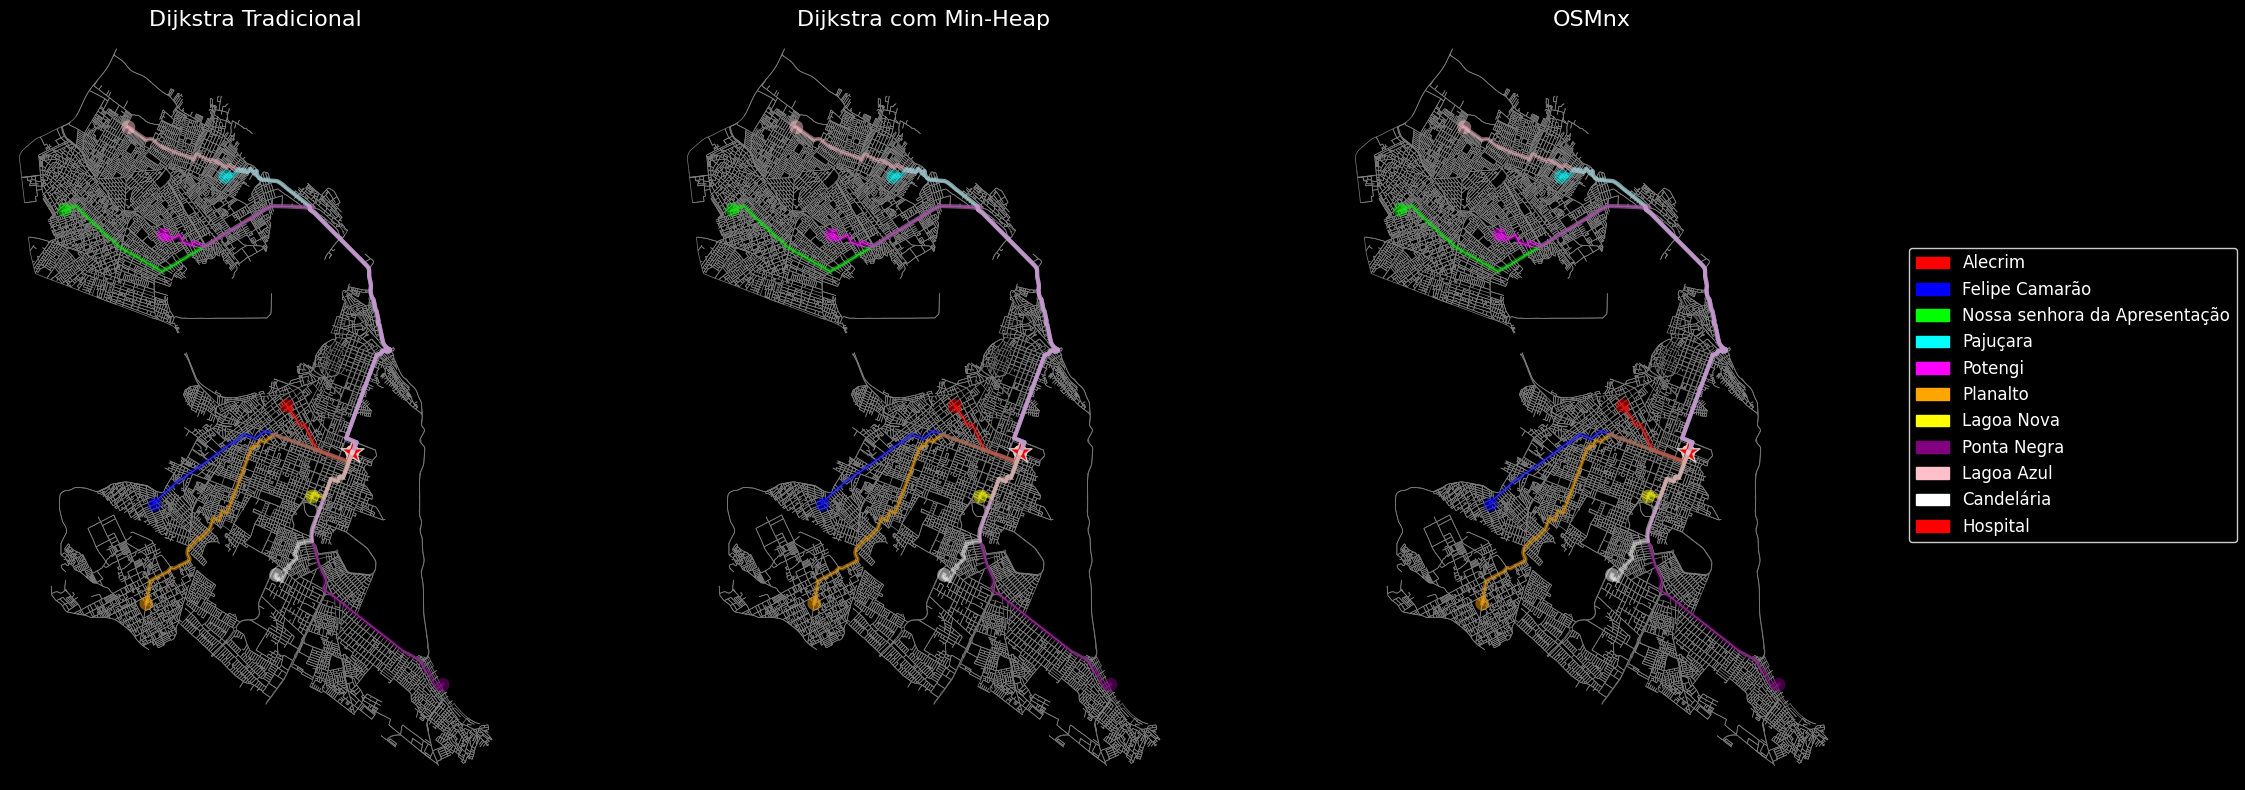

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


bairro_names = [
    "Alecrim",
    "Felipe Camarão",
    "Nossa senhora da Apresentação",
    "Pajuçara",
    "Potengi",
    "Planalto",
    "Lagoa Nova",
    "Ponta Negra",
    "Lagoa Azul",
    "Candelária"
]

# Lista de cores para até 10 destinos
cores_destino = ['red', 'blue', 'lime', 'cyan', 'magenta', 'orange', 'yellow', 'purple', 'pink', 'white'][:len(routes_osm)]

# Cria figura com fundo preto
fig, axes = plt.subplots(1, 3, figsize=(24, 8), facecolor='black')

# Títulos
titulos = ["Dijkstra Tradicional", "Dijkstra com Min-Heap", "OSMnx"]

# Lista de rotas para cada algoritmo
todas_rotas = [path_nodes_dijk, path_nodes_heap, routes_osm]

# Criar patches para a legenda
legenda_patches = [mpatches.Patch(color=cores_destino[i], label=bairro_names[i]) for i in range(len(bairro_names))]

# Para cada subplot
for ax, titulo, rotas in zip(axes, titulos, todas_rotas):
    # Define fundo preto do eixo
    ax.set_facecolor('black')

    # Plota o grafo com tema escuro
    ox.plot_graph(
        G,
        ax=ax,
        show=False,
        close=False,
        bgcolor='black',
        node_color='gray',
        edge_color='gray',
        edge_linewidth=0.5,
        node_size=0
    )

    # Plota cada rota com sua cor correspondente
    for i, rota in enumerate(rotas):
        ox.plot_graph_route(
            G,
            rota,
            ax=ax,
            route_color=cores_destino[i],
            route_linewidth=3,
            node_size=0,
            show=False,
            close=False
        )
    # Marcar o hospital como uma estrela vermelha
    hospital_x, hospital_y = G.nodes[hospital_nodes]['x'], G.nodes[hospital_nodes]['y']
    ax.scatter(hospital_x, hospital_y, c='red', marker='*', s=300, edgecolors='#cccccc', label='Hospital Walfredo Gurgel')


    # Título branco para contraste
    ax.set_title(titulo, fontsize=16, color='white')

# Adiciona a legenda na lateral direita
fig.legend(
    handles=legenda_patches + [mpatches.Patch(color='red', label='Hospital')],
    loc='center right',
    fontsize=12,
    facecolor='black',
    edgecolor='white',
    labelcolor='white'
)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Espaço para legenda
plt.show()


O arquivo .csv foi criado com os dados obtidos por cada algoritmo, utilizando um dataframe da biblioteca Pandas. Posteriormente, o arquivo foi exportado para download e análise posterior.

No que diz respeito ao tempo de execução, ao comparar os dois algoritmos de Dijkstra, foi observado que o Dijkstra com min-heap apresentou tempos significativamente menores em relação ao Dijkstra tradicional. Isso se deve ao fato de que o min-heap utiliza uma estrutura de dados otimizada — o minimum heap — que permite priorizar a expansão do nó com menor distância, tornando a busca mais eficiente.

Ao comparar os resultados do OSMNx com os algoritmos de Dijkstra, nota-se que, na maioria dos trajetos, o OSMNx apresentou desempenho ligeiramente superior, sendo mais rápido que o Dijkstra tradicional e, em alguns casos, também que o Dijkstra com min-heap. No entanto, em outras situações, o OSMNx mostrou-se mais lento, o que pode ser explicado pela complexidade dos grafos de redes viárias reais com os quais a biblioteca trabalha, os quais exigem mais tempo de processamento para sua construção e manipulação, em comparação aos grafos simplificados utilizados nas implementações básicas de Dijkstra.

**Gráfico dos tempos de execução dos algoritmos**

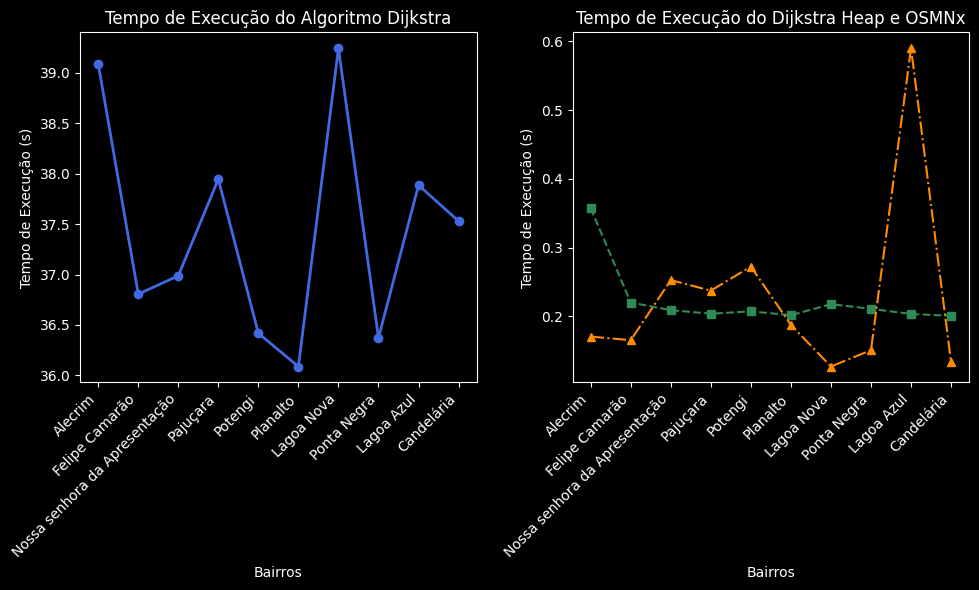

In [ ]:
#Graficos dos tempos de execução dos algoritmos

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(bairro_names, time_exec_dijk, marker='o', linestyle='-', color='royalblue', linewidth=2)
plt.title('Tempo de Execução do Algoritmo Dijkstra')
plt.xlabel('Bairros')
plt.ylabel('Tempo de Execução (s)')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
plt.plot(bairro_names, time_exec_heap, marker='s', linestyle='--', color='seagreen', label='Dijkstra com Heap')
plt.plot(bairro_names, time_exec_osm, marker='^', linestyle='-.', color='darkorange', label='OSMnx')
plt.title('Tempo de Execução do Dijkstra Heap e OSMNx')
plt.xlabel('Bairros')
plt.ylabel('Tempo de Execução (s)')
plt.xticks(rotation=45, ha='right')

# Estilização

plt.tight_layout()
plt.show()


**Gráfico comparativo das emissões de carbono dos algoritmos**

Quanto às emissões de carbono, os valores obtidos para os três algoritmos foram bastante semelhantes, principalmente entre o Dijkstra com min-heap e o OSMNx. Isso indica que, do ponto de vista ambiental, a escolha do algoritmo tem um impacto mínimo.

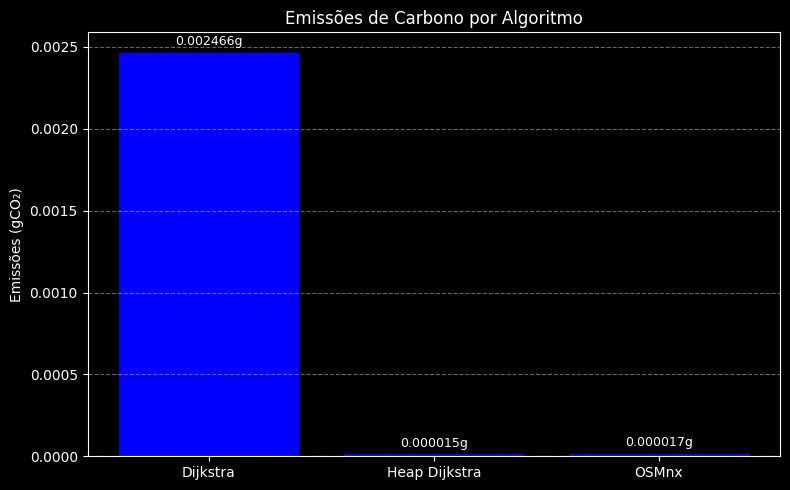

In [ ]:
# Dados
emissions = [emissions_dijk, emissions_heap, emissions_osm]
algorithms = ['Dijkstra', 'Heap Dijkstra', 'OSMnx']

# Gráfico de Emissões de Carbono
plt.figure(figsize=(8, 5))
bars = plt.bar(algorithms, emissions, color='blue')
plt.title('Emissões de Carbono por Algoritmo')
plt.ylabel('Emissões (gCO₂)')

# Anotação no topo de cada barra
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.6f}g',  # <-- 6 casas decimais
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



**Gerando arquivo .csv com os dados**

In [ ]:
import pandas as pd
import csv

# Seus dados (certifique-se de que 'bairros' esteja na primeira posição)
data_list = [bairro_names] + [distance_meters_dijk, time_exec_dijk, [emissions_dijk] * len(bairros), #emissions_dijk modified here
                         distance_meters_heap, time_exec_heap, [emissions_heap] * len(bairros),# emissions_heap modified here
                         distance_meters_osm, time_exec_osm, [emissions_osm] * len(bairros)] #emissions_osm modified here

# Transpondo os dados para facilitar a escrita por linha
data_transposed = list(zip(*data_list))

# Nome do arquivo CSV
csv_file = 'analise_menor_caminho_com_cabecalho_extra.csv'

with open(csv_file, 'w', newline='') as f:
    writer = csv.writer(f)
    # Escrevendo a linha do cabeçalho extra
    writer.writerow(['', 'Dijkstra', '', '', 'Dijkstra Heap', '', '', 'OSMNX', '', ''])
    # Escrevendo o cabeçalho do DataFrame
    writer.writerow(['Bairro', 'Distância', 'Tempo de Execução', 'Emissões de Carbono',
                     'Distância', 'Tempo de Execução', 'Emissões de Carbono',
                     'Distância', 'Tempo de Execução', 'Emissões de Carbono'])
    # Escrevendo os dados
    writer.writerows(data_transposed)

print(f"\nOs resultados foram salvos no arquivo '{csv_file}' com um cabeçalho extra.")



Os resultados foram salvos no arquivo 'analise_menor_caminho_com_cabecalho_extra.csv' com um cabeçalho extra.


#Conclusão

Em suma, os dados sugerem que o Dijkstra com min-heap é o mais eficiente em termos de tempo de execução, enquanto os três algoritmos resultam em emissões de carbono muito semelhantes, fortemente influenciadas pela distância percorrida. O OSMnx, embora possa ser mais lento em alguns casos devido à complexidade dos dados que manipula, oferece a vantagem de trabalhar com redes viárias reais e pode fornecer resultados de caminho mais práticos para aplicações do mundo real.